# Introduction
In this note book, we will simulate a circuit containing only one TBU element, and verify the simulation result with a well-known commerical simulator, Lumerical Interconnect. Then, we will verify our gradient calculation is correct by comparing with numerical differentiation.

**Note**: Please make sure you start a jupyter notebook in the folder 'lesson1_verify_tbu'. Otherwise, the image imported below might not display correcly.

## Part I: Verify Simulation Validity by Comparing with Lumerical Interconnect

Before running the following code, please see the folder 'lumerical_files'. We have provided 
'circuit1.icp'. Its simulation results are run by us and provided in 'circuit1_real.txt' and
'circuit1_imag.txt'. If you want to re-simulate 'circuit1.icp' by yourself, please read the 
following paragraphs. **Otherwise, you could direcly jump to the next cell.** 'circuit1.icp' 
is a file that could be direcly run by Lumerical Interconnect. Once you open Lumerical Interconnect 
and load 'circuit1.icp', you should see 
<img src="lumerical_files/tbu_compound.jpg" width="300"/>

After right clicking it and choose 'expand', we could see the detailed connections as follows. The red marks are added to highlight some model parameters. Note that WGD_1 and WGD_2 are identical. Note that we have deliberately messed up with the parameters (e.g., using 0.74pi instead of 0pi), in case that during comparison, our simulator gives the correct simulation result by dumb luck.
<img src="lumerical_files/tbu_expanded.jpg" width="500"/>

The parameter settings of waveguide are detailed in the following figure:

<img src="lumerical_files/wg_setting.jpg" width="400"/>



We need to clarify on two parameters here. In the waveguide model defined in Lumerical Interconnect, it has a parameter called '$loss$', which is in unit dB/m. In our waveguide model, we have a parameter called '$\alpha$' plays a similar role. They are related by: $loss = |\frac{20}{L} \log_{10}\alpha|$. As will be seen, we set $alpha=0.95$ and $L=250$ (um) in our model, which corresponds to $loss=1782.11$ (dB/m) in Interconnect.


Similarly, the directional coupler (DC) model in Lumerical Interconnect, is based on a parameter called 'coupling coeffient' (referred to as $coeff$). In our DC model, we use a parameter called 'couping angle' (referred to as $cpangle$). They are related by: $coeff = sin^2(cpangle)$. In the integrated TBU model, they are two DCs, thus in our DC model, we use 'cp_left' and 'cp_right' to represent the coupling angle of the left and right DC, respectively.

In [1]:
from spode.core import Circuit, FreeLightSpeed
import numpy as np
import matplotlib.pyplot as plt
import os

# For detailed meaning of each attribute, and how to define a TBU, please refer to the document.
# As could be seen, the model defined here is the same as in 'circuit.icp' described in the previous cell. 

circuit_element = {
    'tbum1': {'ln': ['n1', 'n2'], 'rn': ['n3', 'n4'], 'theta':  0.74 * np.pi, 'phi': -0.53 * np.pi, 'L': 250e-6,
              'cp_left': 0.25 * np.pi + 0.12 * np.pi, 'cp_right': 0.25 * np.pi - 0.17 * np.pi, 'alpha': 0.95}}

mode_info = {'neff': 2.35, 'ng': 4.0, 'wl': 1550e-9}
omega = np.linspace(192.5, 193.5, 1000) * 1e12 * 2 * np.pi
prob_node = ['n4']
deri_node = ['n4']
srce_node = {'n1': 1.0}
deri_vari = ['tbum1::theta', 'tbum1::theta']

circuit = Circuit(circuit_element=circuit_element,
                  mode_info=mode_info,
                  omega=omega,
                  srce_node=srce_node,
                  prob_node=prob_node,
                  deri_node=deri_node,
                  deri_vari=deri_vari)

response, grads = circuit.solve()

# response shape: (len(self.prob_node), len(omega), 2). In our case, shape is (1,1000,2)
# grads shape: (len(deri_node), len(deri_vari), len(omega), 2). In our case, shape is (1,2,2,2)


# Both these two variables have last dimension equal to 2. Because at one port, there are two magnitudes
# for inward and outward directions, respectively. For a floating node (a node with only one circuit element
# connected), the outward optical signal stores at index=1, while the inward optical signal stores at index=0.

outward_ind = 1

In [2]:
# a helper function for reading the simulation result of Lumerical Interconnect
def parse_lumerical_result(file_path):
    wl, result = [], []
    with open(file_path, 'r') as f:
        for line_num, line in enumerate(f.readlines()):
            if line_num >= 3:  # the saved lumerical txt file contains data starting from the third line
                cur_line = line.strip().split(',')
                if len(cur_line) == 2 and cur_line[0] and cur_line[1]:
                    wl.append(eval(cur_line[0]))
                    result.append(eval(cur_line[1]))
    return wl, result


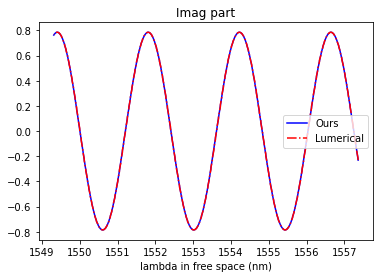

In [3]:
plt.figure()
plt.plot(2 * np.pi * FreeLightSpeed / circuit.omega * 1e9, np.imag(response[0, :, outward_ind]), 'blue', linestyle='-',
         label='Ours')

file_path = './lumerical_files/circuit1_imag.txt'
if os.path.exists(file_path):
    wl, result = parse_lumerical_result(file_path)
    plt.plot(wl, result, 'r', linestyle='-.', label='Lumerical')

plt.xlabel('lambda in free space (nm)')
plt.legend()
plt.title('Imag part')
plt.show()

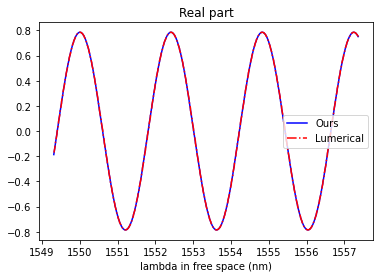

In [4]:
plt.figure()
plt.plot(2 * np.pi * FreeLightSpeed / circuit.omega * 1e9, np.real(response[0, :, outward_ind]), 'blue', linestyle='-',
         label='Ours')

file_path = './lumerical_files/circuit1_real.txt'
if os.path.exists(file_path):
    wl, result = parse_lumerical_result(file_path)
    plt.plot(wl, result, 'r', linestyle='-.', label='Lumerical')

plt.xlabel('lambda in free space (nm)')
plt.legend()
plt.title('Real part')
plt.show()

Ok, it is obvious that our simulator gives exactly the same as Lumerical Interconnect! 

## Part II: Verify Our Gradient Calculation